**Group Members:**
1. Nguyễn Hoài An
2. Hoàng Thùy Dương
3. Phạm Thị Hà

# Dataset

https://www.kaggle.com/datasets/andrewmvd/face-mask-detection/data

Masks play a crucial role in protecting the health of individuals against respiratory diseases, as is one of the few precautions available for COVID-19 in the absence of immunization. With this dataset, it is possible to create a model to detect people wearing masks, not wearing them, or wearing masks improperly.
This dataset contains 853 images belonging to the 3 classes, as well as their bounding boxes in the PASCAL VOC format.
The classes are:

- With mask

- Without mask

- Mask worn incorrectly

# Setup and Install

In [ ]:
print("=== Cài đặt thư viện cần thiết ===")

# Cài đặt các thư viện
!pip install -q ultralytics
!pip install -q kaggle
!pip install -q torch torchvision
!pip install -q pillow
!pip install -q opencv-python
!pip install -q matplotlib
!pip install -q scikit-learn

import os
import shutil
import xml.etree.ElementTree as ET
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from google.colab import files
from tqdm import tqdm
from ultralytics import YOLO

=== Cài đặt thư viện cần thiết ===
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Download dataset from Kaggle

In [ ]:
print("\n=== Cấu hình Kaggle API ===")
print("Vui lòng upload file kaggle.json của bạn:")

# Upload kaggle.json
uploaded = files.upload()

# Tạo thư mục .kaggle và copy file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Tải dataset
print("\n=== Đang tải dataset Face Mask Detection ===")
!kaggle datasets download -d andrewmvd/face-mask-detection
!unzip -q face-mask-detection.zip -d face-mask-data


=== Cấu hình Kaggle API ===
Vui lòng upload file kaggle.json của bạn:


Saving kaggle.json to kaggle.json

=== Đang tải dataset Face Mask Detection ===
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
License(s): CC0-1.0
 98% 389M/398M [00:00<00:00, 471MB/s]
100% 398M/398M [00:00<00:00, 544MB/s]


# Prepare data

In [ ]:
print("\n=== Chuẩn bị dữ liệu ===")

# Đường dẫn
data_dir = Path('face-mask-data')
images_dir = data_dir / 'images'
annotations_dir = data_dir / 'annotations'

# Class mapping
class_names = ['with_mask', 'without_mask', 'mask_weared_incorrect']
class_to_idx = {name: idx + 1 for idx, name in enumerate(class_names)}  # 0 là background

print(f"Số lượng ảnh: {len(list(images_dir.glob('*.png')))}")
print(f"Classes: {class_names}")



=== Chuẩn bị dữ liệu ===
Số lượng ảnh: 853
Classes: ['with_mask', 'without_mask', 'mask_weared_incorrect']


In [ ]:
class_to_idx

{'with_mask': 1, 'without_mask': 2, 'mask_weared_incorrect': 3}

# EDA

In [ ]:
def parse_xml_annotation(xml_path):
    """Parse XML annotation file"""
    tree = ET.parse(xml_path)
    root = tree.getroot()

    boxes = []
    labels = []

    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')

        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)

    return boxes, labels, width, height


=== BẮT ĐẦU EDA ===

 Hiển thị 5 ảnh mẫu kèm Ground Truth:


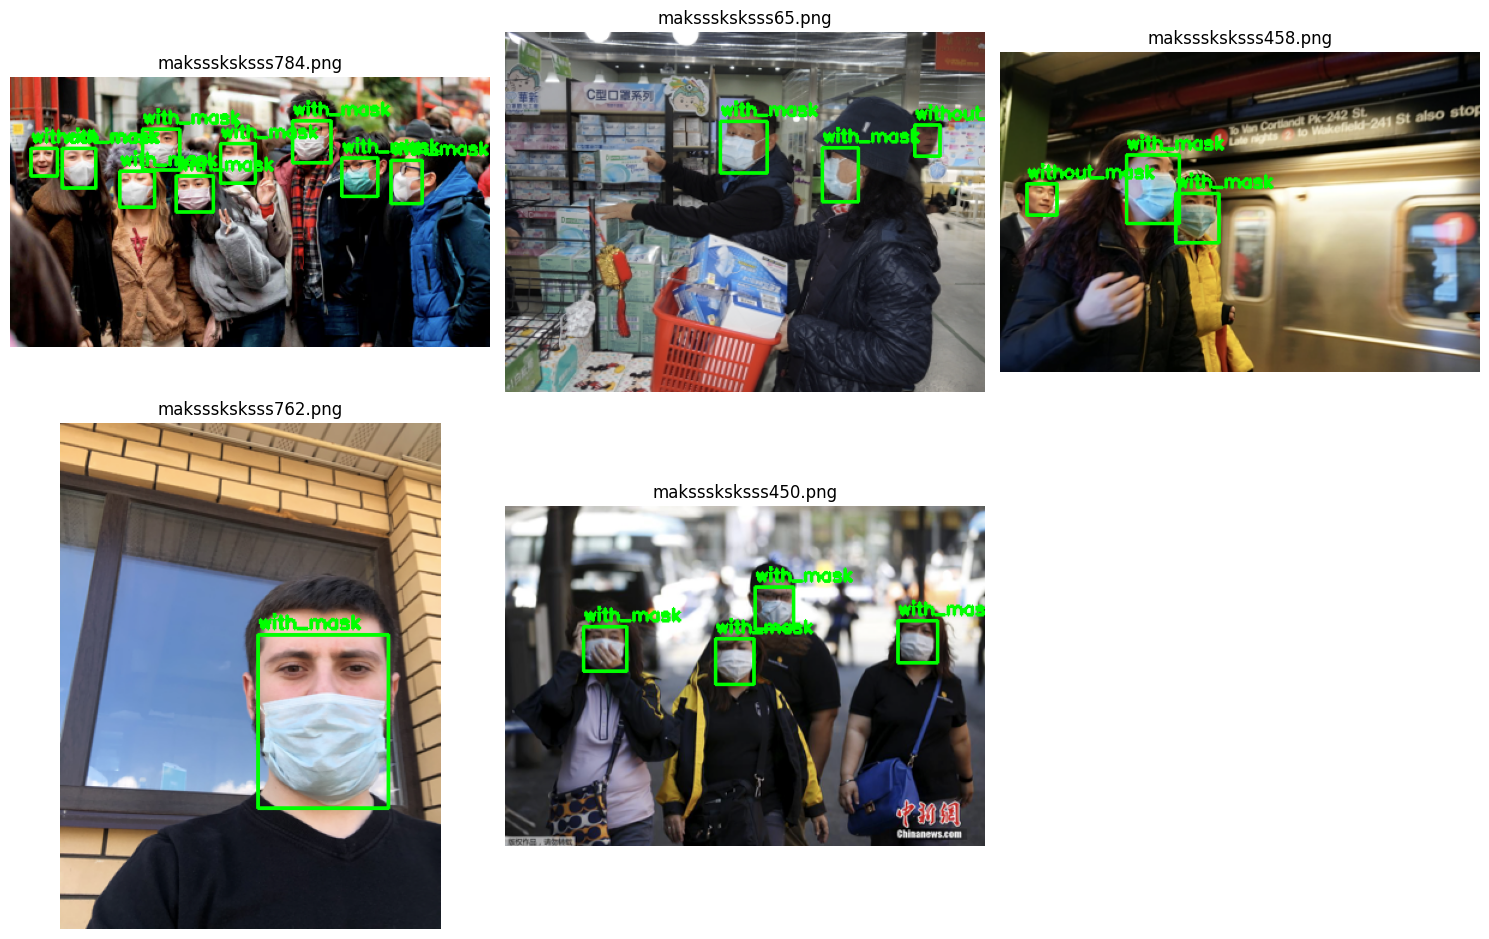


📊 Phân tích kích thước ảnh:
  - Kích thước trung bình (Width x Height): 370.59 x 309.29
  - Kích thước nhỏ nhất (Width x Height): 193 x 156
  - Kích thước lớn nhất (Width x Height): 600 x 600


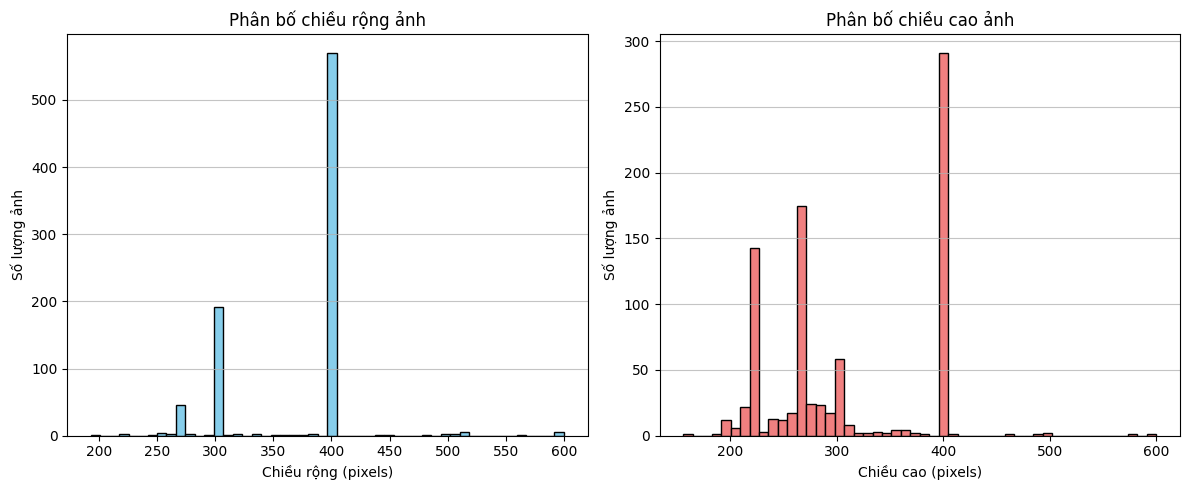


 Hoàn thành EDA


In [ ]:
print("\n=== BẮT ĐẦU EDA ===")

# --- Visualize một vài ảnh kèm bounding boxes và labels ---
print("\n Hiển thị 5 ảnh mẫu kèm Ground Truth:")
sample_images = np.random.choice(list(images_dir.glob('*.png')), 5, replace=False)

plt.figure(figsize=(15, 10))
for i, img_path in enumerate(sample_images):
    xml_path = annotations_dir / (img_path.stem + '.xml')
    boxes, labels, _, _ = parse_xml_annotation(xml_path)

    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img_rgb)
    plt.title(img_path.name)
    plt.axis('off')

    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(img_rgb, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(img_rgb, label, (xmin, ymin-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    plt.imshow(img_rgb)

plt.tight_layout()
plt.show()


# --- Phân tích kích thước ảnh ---
print("\n📊 Phân tích kích thước ảnh:")
image_widths = []
image_heights = []

for img_path in images_dir.glob('*.png'):
    try:
        with Image.open(img_path) as img:
            width, height = img.size
            image_widths.append(width)
            image_heights.append(height)
    except Exception as e:
        print(f"Không thể đọc ảnh {img_path}: {e}")


if image_widths and image_heights:
    print(f"  - Kích thước trung bình (Width x Height): {np.mean(image_widths):.2f} x {np.mean(image_heights):.2f}")
    print(f"  - Kích thước nhỏ nhất (Width x Height): {np.min(image_widths)} x {np.min(image_heights)}")
    print(f"  - Kích thước lớn nhất (Width x Height): {np.max(image_widths)} x {np.max(image_heights)}")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(image_widths, bins=50, color='skyblue', edgecolor='black')
    plt.title('Phân bố chiều rộng ảnh')
    plt.xlabel('Chiều rộng (pixels)')
    plt.ylabel('Số lượng ảnh')
    plt.grid(axis='y', alpha=0.75)

    plt.subplot(1, 2, 2)
    plt.hist(image_heights, bins=50, color='lightcoral', edgecolor='black')
    plt.title('Phân bố chiều cao ảnh')
    plt.xlabel('Chiều cao (pixels)')
    plt.ylabel('Số lượng ảnh')
    plt.grid(axis='y', alpha=0.75)

    plt.tight_layout()
    plt.show()
else:
    print("Không tìm thấy ảnh hoặc không thể đọc kích thước ảnh.")

print("\n Hoàn thành EDA")

# Prepare data for YOLO12

In [ ]:
def convert_to_yolo_format(boxes, labels, img_width, img_height):
    """Chuyển đổi bounding boxes sang YOLO format"""
    yolo_annotations = []

    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box

        # Tính center, width, height (normalized)
        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        class_id = class_to_idx[label] - 1  # YOLO bắt đầu từ 0

        yolo_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}")

    return yolo_annotations

# Tạo cấu trúc thư mục cho YOLO
yolo_dir = Path('yolo_dataset')
(yolo_dir / 'images' / 'train').mkdir(parents=True, exist_ok=True)
(yolo_dir / 'images' / 'val').mkdir(parents=True, exist_ok=True)
(yolo_dir / 'labels' / 'train').mkdir(parents=True, exist_ok=True)
(yolo_dir / 'labels' / 'val').mkdir(parents=True, exist_ok=True)

# Lấy danh sách tất cả các ảnh
all_images = list(images_dir.glob('*.png'))
train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")

# Xử lý và chuyển đổi dữ liệu
for split, image_list in [('train', train_images), ('val', val_images)]:
    for img_path in image_list:
        xml_path = annotations_dir / (img_path.stem + '.xml')

        if xml_path.exists():
            # Parse annotation
            boxes, labels, width, height = parse_xml_annotation(xml_path)

            # Convert to YOLO format
            yolo_annotations = convert_to_yolo_format(boxes, labels, width, height)

            # Copy image
            shutil.copy(img_path, yolo_dir / 'images' / split / img_path.name)

            # Save YOLO annotation
            label_path = yolo_dir / 'labels' / split / (img_path.stem + '.txt')
            with open(label_path, 'w') as f:
                f.write('\n'.join(yolo_annotations))

# Tạo file data.yaml cho YOLO
yaml_content = f"""path: /content/yolo_dataset
train: images/train
val: images/val

nc: {len(class_names)}
names: {class_names}
"""

with open(yolo_dir / 'data.yaml', 'w') as f:
    f.write(yaml_content)

print("Hoàn thành chuẩn bị dữ liệu cho YOLO")

Training images: 682
Validation images: 171
Hoàn thành chuẩn bị dữ liệu cho YOLO


# Train YOLO12

In [ ]:
print("\n=== BẮT ĐẦU TRAIN YOLO ===")

from ultralytics import YOLO

# Load pretrained YOLOv12
model_yolo = YOLO('yolo12n.pt')  # nano model

# Train
results_yolo = model_yolo.train(
    data=str(yolo_dir / 'data.yaml'),
    epochs=30,
    imgsz=640,
    batch=16,
    project='face_mask_detection',
    name='face_mask_yolo',
    patience=10,
    save=True,
    plots=True,
    workers=2,
    pretrained=True,
    exist_ok=True,
    optimizer='auto',
    verbose=True,
    deterministic=True,
    val=True,
    cache=False,  # Disable caching to save memory


)

print("Hoàn thành train YOLO")


=== BẮT ĐẦU TRAIN YOLO ===
Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=face_mask_yolo, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspe

MODEL EVALUATION
Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,557,313 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4936.4±390.5 MB/s, size: 605.2 KB)
val: Scanning /content/yolo_dataset/labels/val.cache... 171 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 171/171 339.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 1.8it/s 6.2s
                   all        171        808      0.901       0.73      0.812      0.551
             with_mask        157        595      0.933      0.894      0.954      0.669
          without_mask         59        182      0.822       0.72      0.799      0.493
 mask_weared_incorrect         27         31      0.947      0.578      0.683      0.489
Speed: 3.3ms preprocess, 12.5ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to /content/run

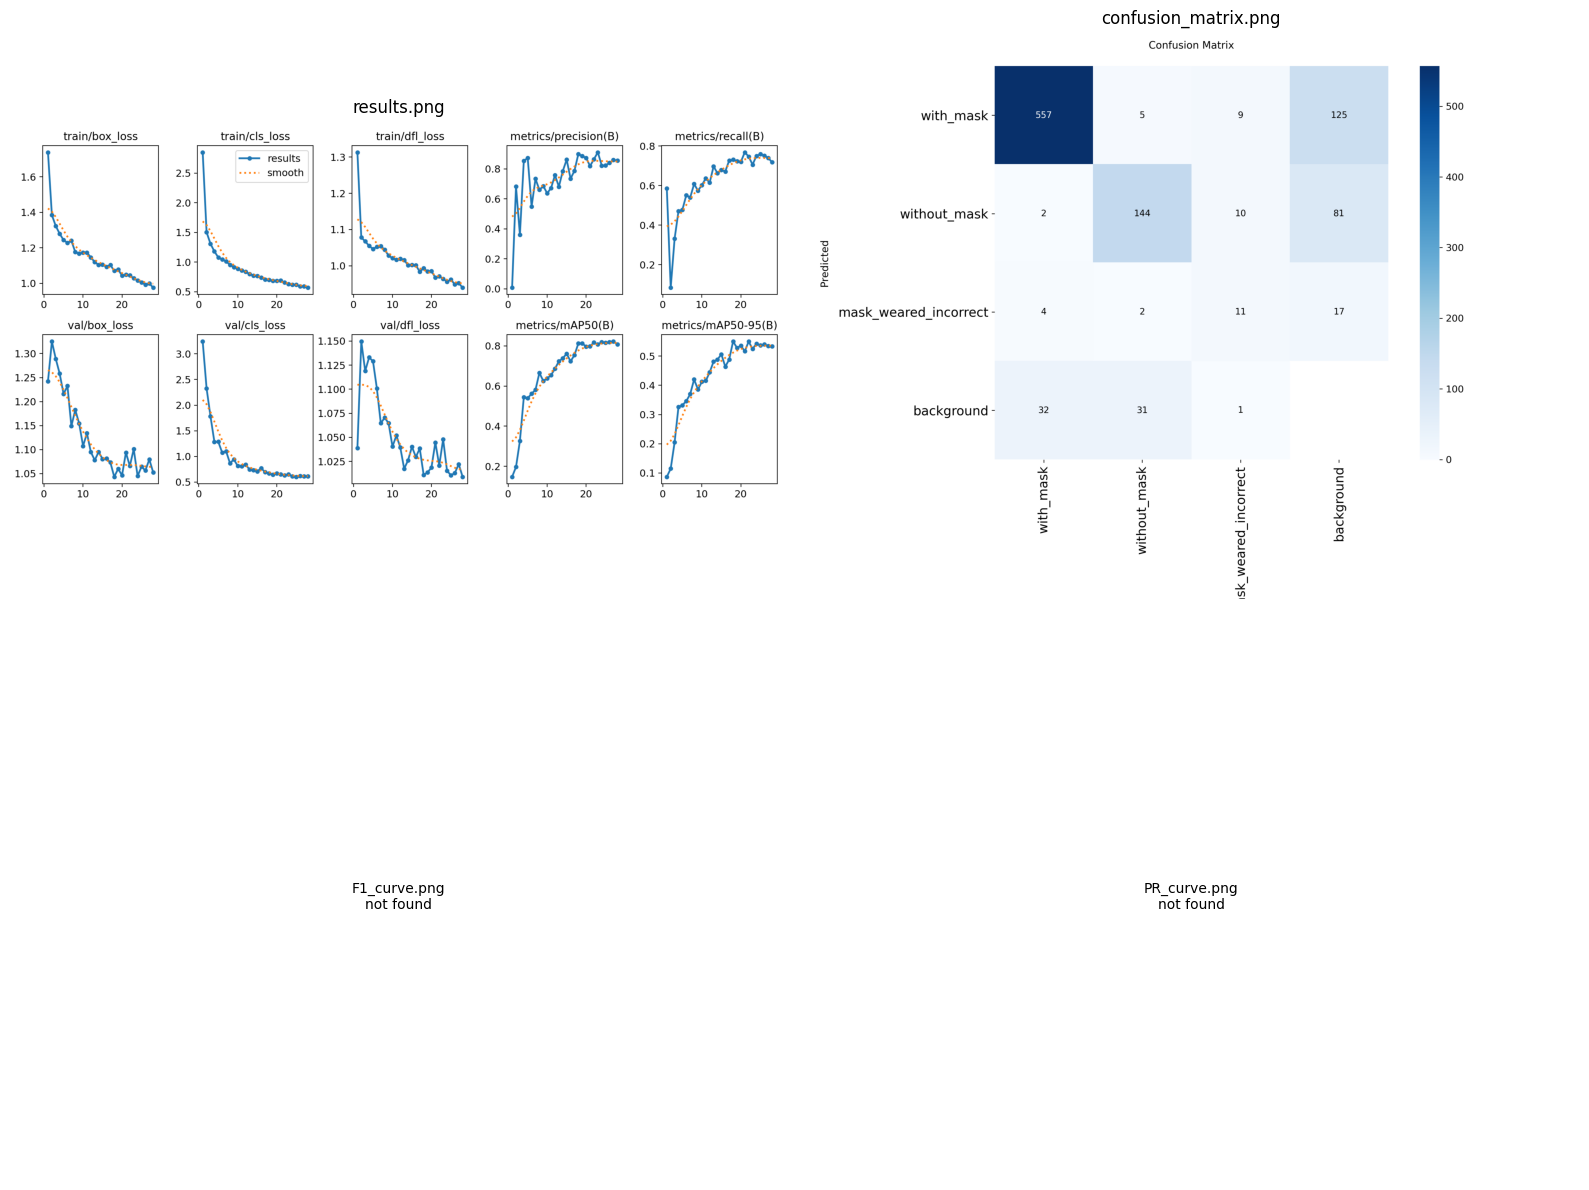

In [ ]:
print("="*60)
print("MODEL EVALUATION")
print("="*60)

# Validate the model
metrics = model_yolo.val()

print("\nValidation Metrics:")
print("="*60)
print(f"mAP50:          {metrics.box.map50:.4f}")
print(f"mAP50-95:       {metrics.box.map:.4f}")
print(f"Precision:      {metrics.box.mp:.4f}")
print(f"Recall:         {metrics.box.mr:.4f}")
print("="*60)

# Display training results
results_dir = '/content/face_mask_detection/face_mask_yolo'
if os.path.exists(results_dir):
    print("\n✓ Training results saved to:", results_dir)

    # Show training plots
    plots = ['results.png', 'confusion_matrix.png', 'F1_curve.png', 'PR_curve.png']

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, plot_name in enumerate(plots):
        plot_path = os.path.join(results_dir, plot_name)
        if os.path.exists(plot_path):
            img = plt.imread(plot_path)
            axes[idx].imshow(img)
            axes[idx].axis('off')
            axes[idx].set_title(plot_name)
        else:
            axes[idx].text(0.5, 0.5, f'{plot_name}\nnot found',
                          ha='center', va='center')
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()


# Prepare data for Faster RCNN

In [ ]:
print("\n=== Chuẩn bị dữ liệu cho Faster R-CNN ===")

class FaceMaskDataset(Dataset):
    def __init__(self, image_paths, annotations_dir, transforms=None):
        self.image_paths = image_paths
        self.annotations_dir = annotations_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        xml_path = self.annotations_dir / (img_path.stem + '.xml')

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Parse annotation
        boxes, labels, _, _ = parse_xml_annotation(xml_path)

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor([class_to_idx[label] for label in labels], dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])

        if self.transforms:
            img = self.transforms(img)

        return img, target

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# Tạo datasets
train_dataset = FaceMaskDataset(train_images, annotations_dir, get_transform(train=True))
val_dataset = FaceMaskDataset(val_images, annotations_dir, get_transform(train=False))

# Collate function
def collate_fn(batch):
    return tuple(zip(*batch))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                         num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False,
                       num_workers=2, collate_fn=collate_fn)

print("Hoàn thành chuẩn bị dữ liệu cho Faster R-CNN")


=== Chuẩn bị dữ liệu cho Faster R-CNN ===
Hoàn thành chuẩn bị dữ liệu cho Faster R-CNN


In [ ]:
def get_model(num_classes):
    # Load pretrained Faster R-CNN
    model = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

    # Thay đổi head để phù hợp với số classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# Model
num_classes = len(class_names) + 1  # +1 cho background
model_frcnn = get_model(num_classes)
model_frcnn.to(device)

# Optimizer
params = [p for p in model_frcnn.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


100%|██████████| 74.2M/74.2M [00:02<00:00, 31.2MB/s]


In [ ]:
# ========== HELPER FUNCTIONS CHO METRICS ==========
def calculate_iou_metric(box1, box2):
    """Tính IoU giữa 2 boxes"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0

def calculate_map(predictions_list, targets_list, iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]):
    """Tính mAP@IoU_thresholds cho tất cả classes"""
    aps_per_threshold = []

    for iou_thresh in iou_thresholds:
        # Tính AP cho từng class
        class_aps = []

        for class_id in range(1, len(class_names) + 1):
            # Thu thập predictions và ground truths cho class này
            all_predictions = []
            all_ground_truths = []

            for pred, target in zip(predictions_list, targets_list):
                # Filter predictions cho class này
                class_mask = pred['labels'] == class_id
                pred_boxes = pred['boxes'][class_mask].cpu().numpy()
                pred_scores = pred['scores'][class_mask].cpu().numpy()

                # Filter ground truths cho class này
                gt_mask = target['labels'] == class_id
                gt_boxes = target['boxes'][gt_mask].cpu().numpy()

                # Lưu predictions với scores
                for box, score in zip(pred_boxes, pred_scores):
                    all_predictions.append({
                        'box': box,
                        'score': score,
                        'image_id': len(all_ground_truths)
                    })

                # Lưu ground truths
                all_ground_truths.append({
                    'boxes': gt_boxes,
                    'matched': [False] * len(gt_boxes)
                })

            if len(all_predictions) == 0:
                continue

            # Sort predictions by score (cao -> thấp)
            all_predictions.sort(key=lambda x: x['score'], reverse=True)

            # Tính TP và FP
            tp = np.zeros(len(all_predictions))
            fp = np.zeros(len(all_predictions))
            total_gt = sum(len(gt['boxes']) for gt in all_ground_truths)

            for i, pred in enumerate(all_predictions):
                image_id = pred['image_id']
                pred_box = pred['box']

                if image_id >= len(all_ground_truths):
                    fp[i] = 1
                    continue

                gt_data = all_ground_truths[image_id]
                gt_boxes = gt_data['boxes']

                if len(gt_boxes) == 0:
                    fp[i] = 1
                    continue

                # Tìm GT box có IoU cao nhất
                best_iou = 0
                best_idx = -1
                for j, gt_box in enumerate(gt_boxes):
                    if gt_data['matched'][j]:
                        continue
                    iou = calculate_iou_metric(pred_box, gt_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_idx = j

                if best_iou >= iou_thresh and best_idx != -1:
                    tp[i] = 1
                    gt_data['matched'][best_idx] = True
                else:
                    fp[i] = 1

            # Tính precision và recall
            tp_cumsum = np.cumsum(tp)
            fp_cumsum = np.cumsum(fp)

            recalls = tp_cumsum / (total_gt + 1e-6)
            precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)

            # Tính AP (Area Under Curve)
            ap = 0
            for t in np.arange(0, 1.1, 0.1):
                if np.sum(recalls >= t) == 0:
                    p = 0
                else:
                    p = np.max(precisions[recalls >= t])
                ap += p / 11

            class_aps.append(ap)

        # mAP cho threshold này
        if len(class_aps) > 0:
            aps_per_threshold.append(np.mean(class_aps))
        else:
            aps_per_threshold.append(0)

    map50 = aps_per_threshold[0] if len(aps_per_threshold) > 0 else 0
    map50_95 = np.mean(aps_per_threshold) if len(aps_per_threshold) > 0 else 0

    return map50, map50_95

def calculate_precision_recall_f1(predictions_list, targets_list, iou_threshold=0.5, conf_threshold=0.5):
    """Tính Precision, Recall, F1 tổng thể"""
    total_tp = 0
    total_fp = 0
    total_fn = 0

    for pred, target in zip(predictions_list, targets_list):
        # Filter predictions by confidence
        conf_mask = pred['scores'] > conf_threshold
        pred_boxes = pred['boxes'][conf_mask].cpu().numpy()
        pred_labels = pred['labels'][conf_mask].cpu().numpy()

        gt_boxes = target['boxes'].cpu().numpy()
        gt_labels = target['labels'].cpu().numpy()

        matched_gt = set()

        # Match predictions với ground truths
        for pred_box, pred_label in zip(pred_boxes, pred_labels):
            best_iou = 0
            best_idx = -1

            for gt_idx, (gt_box, gt_label) in enumerate(zip(gt_boxes, gt_labels)):
                if gt_idx in matched_gt or pred_label != gt_label:
                    continue

                iou = calculate_iou_metric(pred_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_idx = gt_idx

            if best_iou >= iou_threshold:
                total_tp += 1
                matched_gt.add(best_idx)
            else:
                total_fp += 1

        # False negatives
        total_fn += len(gt_boxes) - len(matched_gt)

    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

# Train Faster RCNN

In [ ]:
# Training loop
num_epochs = 30


print("\n" + "="*70)
print("BẮT ĐẦU TRAINING FASTER R-CNN")
print("="*70)

best_map50 = 0
train_losses = []
val_losses = []
metrics_history = {
    'map50': [],
    'map50_95': [],
    'precision': [],
    'recall': [],
    'f1': []
}

for epoch in range(num_epochs):
    print(f"\n📊 Epoch {epoch+1}/{num_epochs}")
    print("-" * 80)

    # ========== TRAINING ==========
    model_frcnn.train()
    epoch_loss = 0
    batch_losses = []

    # Progress bar cho training
    # train_pbar = tqdm(train_loader, desc=f"Training  ",
    #                 bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}')
    # Progress bar cho training
    train_pbar = tqdm(train_loader,
                     desc=f"Training ({len(train_dataset)} images)  ",
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}')

    for i, (images, targets) in enumerate(train_pbar):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model_frcnn(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        batch_loss = losses.item()
        epoch_loss += batch_loss
        batch_losses.append(batch_loss)

        # Update progress bar với loss hiện tại
        train_pbar.set_postfix({
            'loss': f'{batch_loss:.4f}',
            'avg': f'{np.mean(batch_losses):.4f}'
        })

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ========== VALIDATION & METRICS CALCULATION ==========
    model_frcnn.eval()
    val_loss = 0
    predictions_list = []
    targets_list = []

    val_pbar = tqdm(val_loader, desc=f"Validation ({len(val_dataset)} images)  ",
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}')

    with torch.no_grad():
        for images, targets in val_pbar:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Calculate loss
            model_frcnn.train()  # Temporary train mode for loss calculation
            loss_dict = model_frcnn(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

            # Get predictions
            model_frcnn.eval()
            predictions = model_frcnn(images)

            predictions_list.extend(predictions)
            targets_list.extend(targets)

            val_pbar.set_postfix({'loss': f'{losses.item():.4f}'})

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # ========== CALCULATE METRICS ==========
    print("\n⏳ Calculating metrics...", end=" ")
    map50, map50_95 = calculate_map(predictions_list, targets_list)
    precision, recall, f1 = calculate_precision_recall_f1(predictions_list, targets_list)
    print("✓")

    metrics_history['map50'].append(map50)
    metrics_history['map50_95'].append(map50_95)
    metrics_history['precision'].append(precision)
    metrics_history['recall'].append(recall)
    metrics_history['f1'].append(f1)

    # ========== LR SCHEDULER ==========
    lr_scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # ========== SUMMARY ==========
    print(f"\n📈 Epoch {epoch+1} Summary:")
    print(f"   {'Metric':<20} {'Value':<10}")
    print(f"   {'-'*30}")
    print(f"   {'Train Loss':<20} {avg_train_loss:.4f}")
    print(f"   {'Val Loss':<20} {avg_val_loss:.4f}")
    print(f"   {'mAP@50':<20} {map50:.4f}")
    print(f"   {'mAP@50-95':<20} {map50_95:.4f}")
    print(f"   {'Precision':<20} {precision:.4f}")
    print(f"   {'Recall':<20} {recall:.4f}")
    print(f"   {'F1-Score':<20} {f1:.4f}")
    print(f"   {'Learning Rate':<20} {current_lr:.6f}")

    # Save best model based on mAP@50
    if map50 > best_map50:
        best_map50 = map50
        torch.save(model_frcnn.state_dict(), 'faster_rcnn_best.pth')
        print(f"   ✓ Best model saved! (mAP@50: {best_map50:.4f})")

    print("-" * 80)

print("\n" + "="*70)
print("HOÀN THÀNH TRAINING")
print("="*70)



BẮT ĐẦU TRAINING FASTER R-CNN

📊 Epoch 1/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.39it/s, loss=0.4102]



⏳ Calculating metrics... ✓

📈 Epoch 1 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.5934
   Val Loss             0.4932
   mAP@50               0.4387
   mAP@50-95            0.2007
   Precision            0.9388
   Recall               0.4938
   F1-Score             0.6472
   Learning Rate        0.005000
   ✓ Best model saved! (mAP@50: 0.4387)
--------------------------------------------------------------------------------

📊 Epoch 2/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.41it/s, loss=0.3198]



⏳ Calculating metrics... ✓

📈 Epoch 2 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.5092
   Val Loss             0.4151
   mAP@50               0.4760
   mAP@50-95            0.2666
   Precision            0.9086
   Recall               0.6522
   F1-Score             0.7594
   Learning Rate        0.005000
   ✓ Best model saved! (mAP@50: 0.4760)
--------------------------------------------------------------------------------

📊 Epoch 3/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.44it/s, loss=0.3311]



⏳ Calculating metrics... ✓

📈 Epoch 3 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4882
   Val Loss             0.4065
   mAP@50               0.5541
   mAP@50-95            0.3155
   Precision            0.8752
   Recall               0.6943
   F1-Score             0.7743
   Learning Rate        0.000500
   ✓ Best model saved! (mAP@50: 0.5541)
--------------------------------------------------------------------------------

📊 Epoch 4/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.47it/s, loss=0.2729]



⏳ Calculating metrics... ✓

📈 Epoch 4 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4798
   Val Loss             0.3873
   mAP@50               0.5187
   mAP@50-95            0.3122
   Precision            0.8978
   Recall               0.6955
   F1-Score             0.7838
   Learning Rate        0.000500
--------------------------------------------------------------------------------

📊 Epoch 5/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.48it/s, loss=0.2676]



⏳ Calculating metrics... ✓

📈 Epoch 5 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4718
   Val Loss             0.3797
   mAP@50               0.5588
   mAP@50-95            0.3364
   Precision            0.8922
   Recall               0.7067
   F1-Score             0.7887
   Learning Rate        0.000500
   ✓ Best model saved! (mAP@50: 0.5588)
--------------------------------------------------------------------------------

📊 Epoch 6/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.48it/s, loss=0.2605]



⏳ Calculating metrics... ✓

📈 Epoch 6 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4599
   Val Loss             0.3732
   mAP@50               0.5341
   mAP@50-95            0.3220
   Precision            0.8786
   Recall               0.7079
   F1-Score             0.7841
   Learning Rate        0.000050
--------------------------------------------------------------------------------

📊 Epoch 7/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.46it/s, loss=0.2609]



⏳ Calculating metrics... ✓

📈 Epoch 7 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4465
   Val Loss             0.3752
   mAP@50               0.5562
   mAP@50-95            0.3359
   Precision            0.8829
   Recall               0.7092
   F1-Score             0.7865
   Learning Rate        0.000050
--------------------------------------------------------------------------------

📊 Epoch 8/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.45it/s, loss=0.2724]



⏳ Calculating metrics... ✓

📈 Epoch 8 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4751
   Val Loss             0.3760
   mAP@50               0.5539
   mAP@50-95            0.3338
   Precision            0.8827
   Recall               0.7079
   F1-Score             0.7857
   Learning Rate        0.000050
--------------------------------------------------------------------------------

📊 Epoch 9/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.44it/s, loss=0.2666]



⏳ Calculating metrics... ✓

📈 Epoch 9 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4631
   Val Loss             0.3763
   mAP@50               0.5534
   mAP@50-95            0.3356
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000005
--------------------------------------------------------------------------------

📊 Epoch 10/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.44it/s, loss=0.2683]



⏳ Calculating metrics... ✓

📈 Epoch 10 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4574
   Val Loss             0.3763
   mAP@50               0.5535
   mAP@50-95            0.3355
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000005
--------------------------------------------------------------------------------

📊 Epoch 11/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.43it/s, loss=0.2621]



⏳ Calculating metrics... ✓

📈 Epoch 11 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4546
   Val Loss             0.3770
   mAP@50               0.5535
   mAP@50-95            0.3355
   Precision            0.8911
   Recall               0.7092
   F1-Score             0.7898
   Learning Rate        0.000005
--------------------------------------------------------------------------------

📊 Epoch 12/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.45it/s, loss=0.2604]



⏳ Calculating metrics... ✓

📈 Epoch 12 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4564
   Val Loss             0.3767
   mAP@50               0.5537
   mAP@50-95            0.3359
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000001
--------------------------------------------------------------------------------

📊 Epoch 13/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.45it/s, loss=0.2610]



⏳ Calculating metrics... ✓

📈 Epoch 13 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4427
   Val Loss             0.3752
   mAP@50               0.5537
   mAP@50-95            0.3360
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000001
--------------------------------------------------------------------------------

📊 Epoch 14/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.49it/s, loss=0.2623]



⏳ Calculating metrics... ✓

📈 Epoch 14 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4435
   Val Loss             0.3767
   mAP@50               0.5537
   mAP@50-95            0.3359
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000001
--------------------------------------------------------------------------------

📊 Epoch 15/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.48it/s, loss=0.2573]



⏳ Calculating metrics... ✓

📈 Epoch 15 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4498
   Val Loss             0.3757
   mAP@50               0.5539
   mAP@50-95            0.3361
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000000
--------------------------------------------------------------------------------

📊 Epoch 16/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.49it/s, loss=0.2583]



⏳ Calculating metrics... ✓

📈 Epoch 16 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4607
   Val Loss             0.3764
   mAP@50               0.5539
   mAP@50-95            0.3361
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000000
--------------------------------------------------------------------------------

📊 Epoch 17/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.47it/s, loss=0.2676]



⏳ Calculating metrics... ✓

📈 Epoch 17 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4519
   Val Loss             0.3765
   mAP@50               0.5539
   mAP@50-95            0.3361
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000000
--------------------------------------------------------------------------------

📊 Epoch 18/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.42it/s, loss=0.2683]



⏳ Calculating metrics... ✓

📈 Epoch 18 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4727
   Val Loss             0.3777
   mAP@50               0.5539
   mAP@50-95            0.3361
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000000
--------------------------------------------------------------------------------

📊 Epoch 19/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.47it/s, loss=0.2586]



⏳ Calculating metrics... ✓

📈 Epoch 19 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4582
   Val Loss             0.3772
   mAP@50               0.5539
   mAP@50-95            0.3361
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000000
--------------------------------------------------------------------------------

📊 Epoch 20/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.43it/s, loss=0.2588]



⏳ Calculating metrics... ✓

📈 Epoch 20 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4664
   Val Loss             0.3754
   mAP@50               0.5539
   mAP@50-95            0.3361
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000000
--------------------------------------------------------------------------------

📊 Epoch 21/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.43it/s, loss=0.2682]



⏳ Calculating metrics... ✓

📈 Epoch 21 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4552
   Val Loss             0.3748
   mAP@50               0.5539
   mAP@50-95            0.3361
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000000
--------------------------------------------------------------------------------

📊 Epoch 22/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.46it/s, loss=0.2554]



⏳ Calculating metrics... ✓

📈 Epoch 22 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4579
   Val Loss             0.3764
   mAP@50               0.5539
   mAP@50-95            0.3361
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000000
--------------------------------------------------------------------------------

📊 Epoch 23/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.43it/s, loss=0.2625]



⏳ Calculating metrics... ✓

📈 Epoch 23 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4531
   Val Loss             0.3769
   mAP@50               0.5539
   mAP@50-95            0.3361
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000000
--------------------------------------------------------------------------------

📊 Epoch 24/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.45it/s, loss=0.2577]



⏳ Calculating metrics... ✓

📈 Epoch 24 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4589
   Val Loss             0.3764
   mAP@50               0.5539
   mAP@50-95            0.3361
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000000
--------------------------------------------------------------------------------

📊 Epoch 25/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.43it/s, loss=0.2643]



⏳ Calculating metrics... ✓

📈 Epoch 25 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4592
   Val Loss             0.3763
   mAP@50               0.5539
   mAP@50-95            0.3361
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000000
--------------------------------------------------------------------------------

📊 Epoch 26/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.44it/s, loss=0.2558]



⏳ Calculating metrics... ✓

📈 Epoch 26 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4582
   Val Loss             0.3757
   mAP@50               0.5539
   mAP@50-95            0.3360
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000000
--------------------------------------------------------------------------------

📊 Epoch 27/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.43it/s, loss=0.2615]



⏳ Calculating metrics... ✓

📈 Epoch 27 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4498
   Val Loss             0.3756
   mAP@50               0.5539
   mAP@50-95            0.3361
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000000
--------------------------------------------------------------------------------

📊 Epoch 28/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.43it/s, loss=0.2622]



⏳ Calculating metrics... ✓

📈 Epoch 28 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4560
   Val Loss             0.3761
   mAP@50               0.5539
   mAP@50-95            0.3361
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000000
--------------------------------------------------------------------------------

📊 Epoch 29/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.45it/s, loss=0.2666]



⏳ Calculating metrics... ✓

📈 Epoch 29 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4557
   Val Loss             0.3764
   mAP@50               0.5539
   mAP@50-95            0.3361
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000000
--------------------------------------------------------------------------------

📊 Epoch 30/30
--------------------------------------------------------------------------------


Validation (171 images)  : 100%|██████████████████████████████| 43/43 [00:12<00:00,  3.34it/s, loss=0.2626]



⏳ Calculating metrics... ✓

📈 Epoch 30 Summary:
   Metric               Value     
   ------------------------------
   Train Loss           0.4440
   Val Loss             0.3758
   mAP@50               0.5539
   mAP@50-95            0.3361
   Precision            0.8910
   Recall               0.7079
   F1-Score             0.7890
   Learning Rate        0.000000
--------------------------------------------------------------------------------

HOÀN THÀNH TRAINING


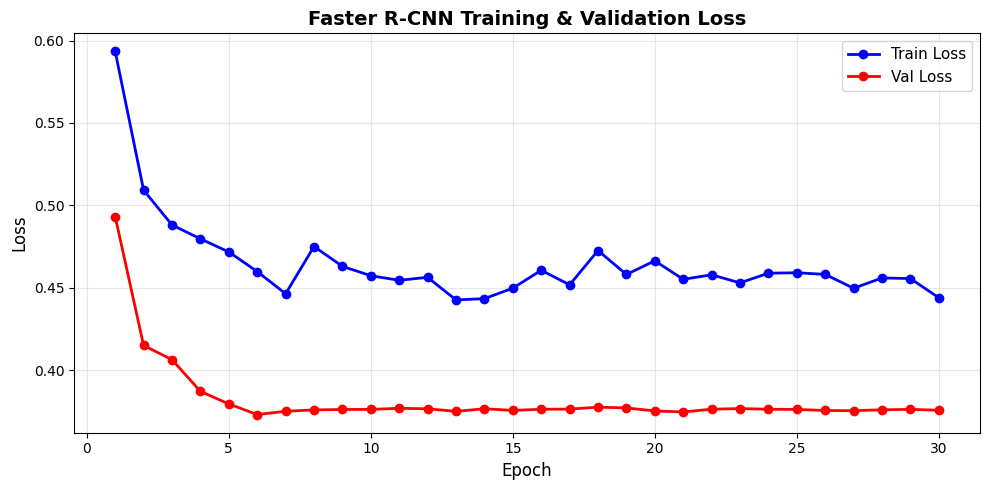


📊 Training Statistics:
   Best Val mAP@50:: 0.5588
   Final Train Loss: 0.4440
   Final Val Loss: 0.3758

💾 Models saved:
   - faster_rcnn_best.pth (best validation loss)
   - faster_rcnn_face_mask.pth (final model)
   - faster_rcnn_loss_curve.png (training curve)


In [ ]:
# Vẽ biểu đồ loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, 'b-o', label='Train Loss', linewidth=2)
plt.plot(range(1, num_epochs+1), val_losses, 'r-o', label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Faster R-CNN Training & Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('faster_rcnn_loss_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Training Statistics:")
print(f"   Best Val mAP@50:: {best_map50:.4f}")
print(f"   Final Train Loss: {train_losses[-1]:.4f}")
print(f"   Final Val Loss: {val_losses[-1]:.4f}")

# Lưu model final
torch.save(model_frcnn.state_dict(), 'faster_rcnn_face_mask.pth')
print("\n💾 Models saved:")
print("   - faster_rcnn_best.pth (best validation loss)")
print("   - faster_rcnn_face_mask.pth (final model)")
print("   - faster_rcnn_loss_curve.png (training curve)")

# Evaluate and visualize results


=== ĐÁNH GIÁ VÀ VISUALIZE KẾT QUẢ ===

Đánh giá YOLO model...
Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,557,313 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3096.1±583.1 MB/s, size: 449.4 KB)
val: Scanning /content/yolo_dataset/labels/val.cache... 171 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 171/171 155.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 1.7it/s 6.6s
                   all        171        808      0.901       0.73      0.812      0.551
             with_mask        157        595      0.933      0.894      0.954      0.669
          without_mask         59        182      0.822       0.72      0.799      0.493
 mask_weared_incorrect         27         31      0.947      0.578      0.683      0.489
Speed: 2.9ms preprocess, 8.3ms inference, 0.0ms loss, 4.5ms postpr

Evaluating: 100%|██████████| 43/43 [00:06<00:00,  6.33it/s]



 Faster R-CNN Results:
   mAP@50: 0.5588
   mAP@50-95: 0.3364
   Precision: 0.8922
   Recall: 0.7067
   F1-Score: 0.7887

Visualizing training history...


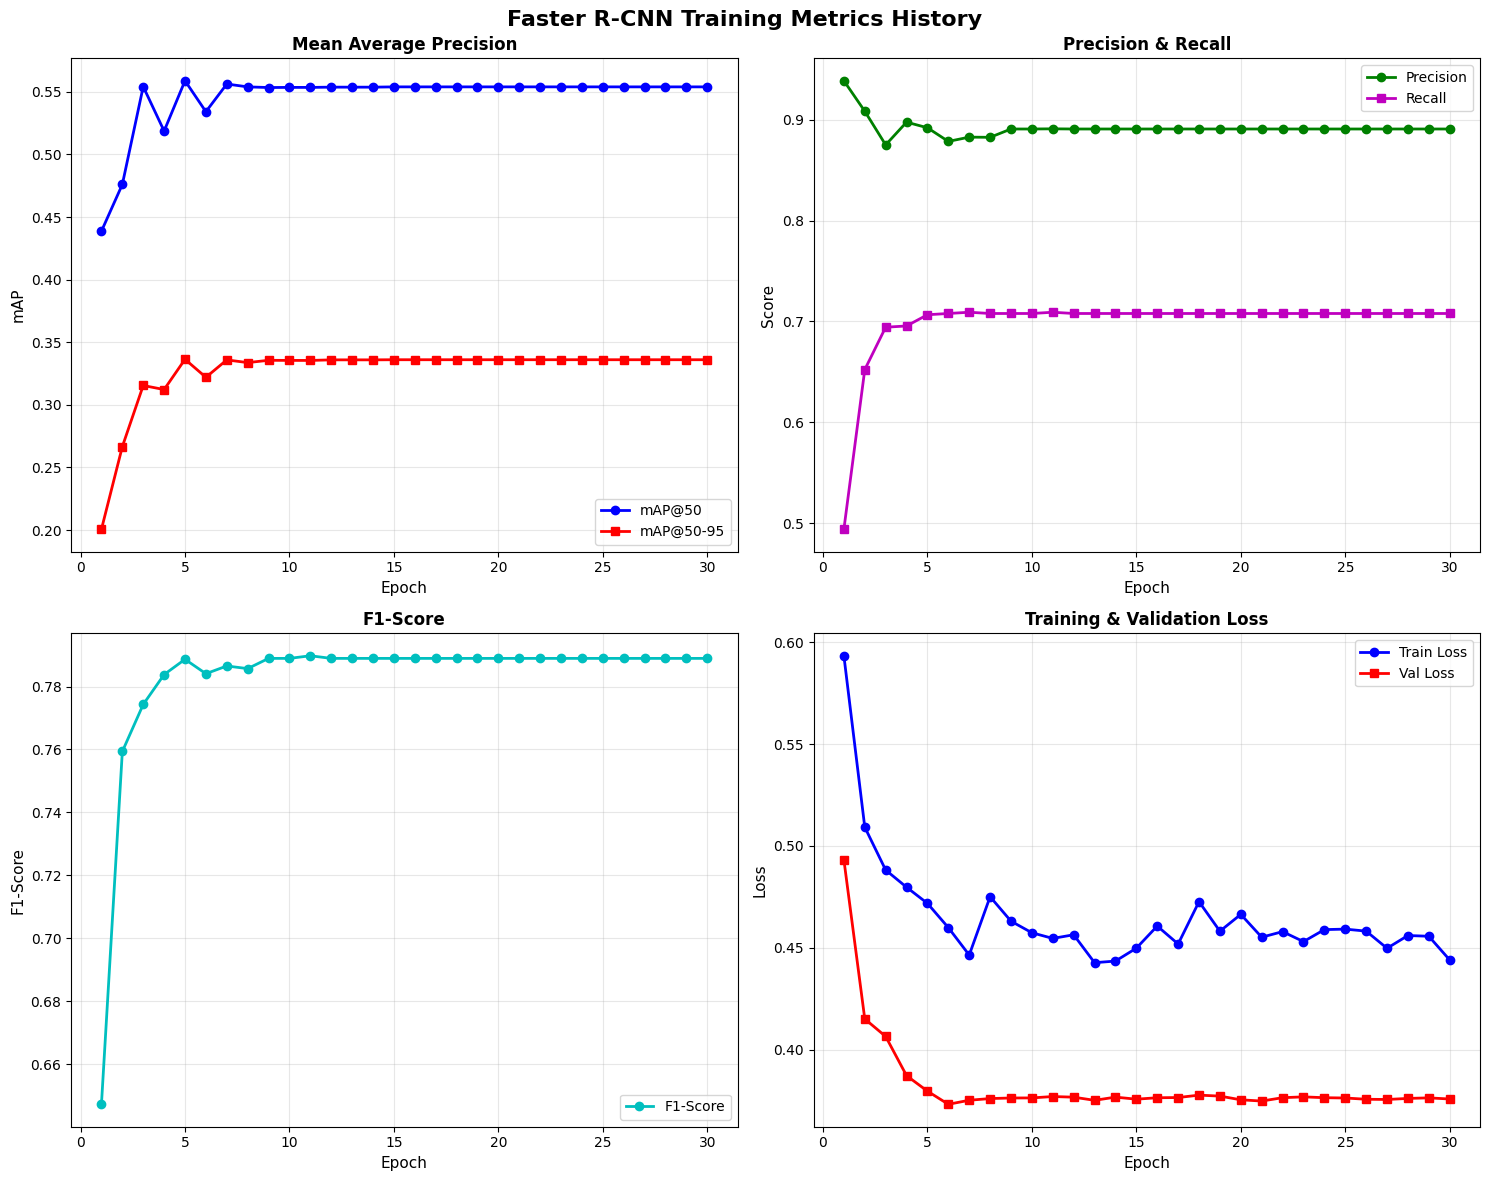

Saved: frcnn_training_history.png


In [ ]:
print("\n=== ĐÁNH GIÁ VÀ VISUALIZE KẾT QUẢ ===")

# ========== 8.1: Đánh giá YOLO ==========
print("\nĐánh giá YOLO model...")

# Load best YOLO model
best_yolo_path = '/content/face_mask_detection/face_mask_yolo/weights/best.pt'
model_yolo_eval = YOLO(best_yolo_path)

# Validate YOLO
yolo_metrics = model_yolo_eval.val(data=str(yolo_dir / 'data.yaml'))

# Extract YOLO metrics
yolo_results = {
    'mAP50': yolo_metrics.box.map50,
    'mAP50-95': yolo_metrics.box.map,
    'Precision': yolo_metrics.box.mp,
    'Recall': yolo_metrics.box.mr,
    'F1': 2 * (yolo_metrics.box.mp * yolo_metrics.box.mr) / (yolo_metrics.box.mp + yolo_metrics.box.mr + 1e-6)
}

print(f"\n YOLO Results:")
print(f"   mAP@50: {yolo_results['mAP50']:.4f}")
print(f"   mAP@50-95: {yolo_results['mAP50-95']:.4f}")
print(f"   Precision: {yolo_results['Precision']:.4f}")
print(f"   Recall: {yolo_results['Recall']:.4f}")
print(f"   F1-Score: {yolo_results['F1']:.4f}")

# ========== 8.2: Đánh giá Faster R-CNN ==========
print("\nĐánh giá Faster R-CNN model...")

# Load best Faster R-CNN model
model_frcnn.load_state_dict(torch.load('faster_rcnn_best.pth'))
model_frcnn.eval()

# Calculate final metrics on validation set
predictions_list_final = []
targets_list_final = []

with torch.no_grad():
    for images, targets in tqdm(val_loader, desc="Evaluating"):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        predictions = model_frcnn(images)
        predictions_list_final.extend(predictions)
        targets_list_final.extend(targets)

# Calculate metrics
frcnn_map50, frcnn_map50_95 = calculate_map(predictions_list_final, targets_list_final)
frcnn_precision, frcnn_recall, frcnn_f1 = calculate_precision_recall_f1(
    predictions_list_final, targets_list_final
)

frcnn_results = {
    'mAP50': frcnn_map50,
    'mAP50-95': frcnn_map50_95,
    'Precision': frcnn_precision,
    'Recall': frcnn_recall,
    'F1': frcnn_f1
}

print(f"\n Faster R-CNN Results:")
print(f"   mAP@50: {frcnn_results['mAP50']:.4f}")
print(f"   mAP@50-95: {frcnn_results['mAP50-95']:.4f}")
print(f"   Precision: {frcnn_results['Precision']:.4f}")
print(f"   Recall: {frcnn_results['Recall']:.4f}")
print(f"   F1-Score: {frcnn_results['F1']:.4f}")

# ========== 8.3: Visualize Training Metrics History ==========
print("\nVisualizing training history...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Faster R-CNN Training Metrics History', fontsize=16, fontweight='bold')

# Plot mAP
axes[0, 0].plot(range(1, num_epochs+1), metrics_history['map50'], 'b-o', label='mAP@50', linewidth=2, markersize=6)
axes[0, 0].plot(range(1, num_epochs+1), metrics_history['map50_95'], 'r-s', label='mAP@50-95', linewidth=2, markersize=6)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('mAP', fontsize=11)
axes[0, 0].set_title('Mean Average Precision', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot Precision & Recall
axes[0, 1].plot(range(1, num_epochs+1), metrics_history['precision'], 'g-o', label='Precision', linewidth=2, markersize=6)
axes[0, 1].plot(range(1, num_epochs+1), metrics_history['recall'], 'm-s', label='Recall', linewidth=2, markersize=6)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Score', fontsize=11)
axes[0, 1].set_title('Precision & Recall', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot F1-Score
axes[1, 0].plot(range(1, num_epochs+1), metrics_history['f1'], 'c-o', label='F1-Score', linewidth=2, markersize=6)
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('F1-Score', fontsize=11)
axes[1, 0].set_title('F1-Score', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Plot Loss
axes[1, 1].plot(range(1, num_epochs+1), train_losses, 'b-o', label='Train Loss', linewidth=2, markersize=6)
axes[1, 1].plot(range(1, num_epochs+1), val_losses, 'r-s', label='Val Loss', linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('Loss', fontsize=11)
axes[1, 1].set_title('Training & Validation Loss', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('frcnn_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: frcnn_training_history.png")

# Compare models

In [ ]:
print("\n" + "="*70)
print("SO SÁNH YOLO vs FASTER R-CNN")
print("="*70)

# ========== 9.1: Bảng so sánh metrics ==========
comparison_df = {
    'Metric': ['mAP@50', 'mAP@50-95', 'Precision', 'Recall', 'F1-Score'],
    'YOLO': [
        f"{yolo_results['mAP50']:.4f}",
        f"{yolo_results['mAP50-95']:.4f}",
        f"{yolo_results['Precision']:.4f}",
        f"{yolo_results['Recall']:.4f}",
        f"{yolo_results['F1']:.4f}"
    ],
    'Faster R-CNN': [
        f"{frcnn_results['mAP50']:.4f}",
        f"{frcnn_results['mAP50-95']:.4f}",
        f"{frcnn_results['Precision']:.4f}",
        f"{frcnn_results['Recall']:.4f}",
        f"{frcnn_results['F1']:.4f}"
    ]
}

print("\nPerformance Comparison:")
print(f"{'Metric':<15} {'YOLO':<15} {'Faster R-CNN':<15} {'Winner':<10}")
print("-" * 60)
for i, metric in enumerate(comparison_df['Metric']):
    yolo_val = float(comparison_df['YOLO'][i])
    frcnn_val = float(comparison_df['Faster R-CNN'][i])
    winner = 'YOLO' if yolo_val > frcnn_val else 'Faster R-CNN' if frcnn_val > yolo_val else 'Tie'
    print(f"{metric:<15} {comparison_df['YOLO'][i]:<15} {comparison_df['Faster R-CNN'][i]:<15} {winner:<10}")


SO SÁNH YOLO vs FASTER R-CNN

Performance Comparison:
Metric          YOLO            Faster R-CNN    Winner    
------------------------------------------------------------
mAP@50          0.8120          0.5588          YOLO      
mAP@50-95       0.5506          0.3364          YOLO      
Precision       0.9009          0.8922          YOLO      
Recall          0.7305          0.7067          YOLO      
F1-Score        0.8068          0.7887          YOLO      



 Creating comparison visualizations...


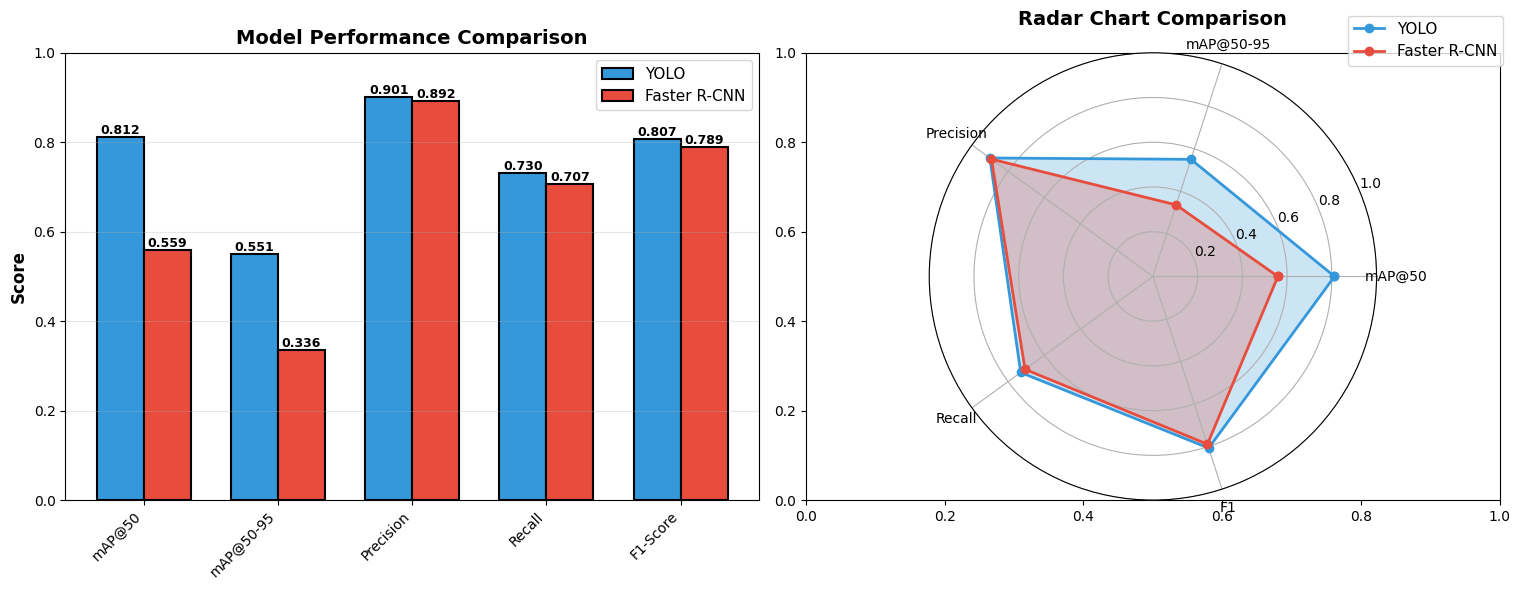

Saved: model_comparison.png


In [ ]:

# ========== 9.2: Visualize so sánh metrics ==========
print("\n Creating comparison visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
metrics = ['mAP@50', 'mAP@50-95', 'Precision', 'Recall', 'F1-Score']
yolo_values = [yolo_results[m.replace('@', '')] if '@' not in m else yolo_results[m.replace('@', '')]
               for m in ['mAP50', 'mAP50-95', 'Precision', 'Recall', 'F1']]
frcnn_values = [frcnn_results[m.replace('@', '')] if '@' not in m else frcnn_results[m.replace('@', '')]
                for m in ['mAP50', 'mAP50-95', 'Precision', 'Recall', 'F1']]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0].bar(x - width/2, yolo_values, width, label='YOLO', color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = axes[0].bar(x + width/2, frcnn_values, width, label='Faster R-CNN', color='#e74c3c', edgecolor='black', linewidth=1.5)

axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.0])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

# Radar chart comparison
categories = ['mAP@50', 'mAP@50-95', 'Precision', 'Recall', 'F1']
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
yolo_values_radar = yolo_values + [yolo_values[0]]
frcnn_values_radar = frcnn_values + [frcnn_values[0]]
angles += angles[:1]

ax = plt.subplot(122, projection='polar')
ax.plot(angles, yolo_values_radar, 'o-', linewidth=2, label='YOLO', color='#3498db')
ax.fill(angles, yolo_values_radar, alpha=0.25, color='#3498db')
ax.plot(angles, frcnn_values_radar, 'o-', linewidth=2, label='Faster R-CNN', color='#e74c3c')
ax.fill(angles, frcnn_values_radar, alpha=0.25, color='#e74c3c')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=10)
ax.set_ylim(0, 1)
ax.set_title('Radar Chart Comparison', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax.grid(True)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: model_comparison.png")

Overall Insight

- YOLO demonstrates better detection accuracy (especially for mAP metrics) while maintaining strong precision and recall.

- Faster R-CNN is reliable but less effective in mean average precision, possibly due to slower inference or more localization errors.


⏱Comparing inference speed...


Faster R-CNN Inference: 100%|██████████| 50/50 [00:02<00:00, 19.30it/s]



Inference Speed Comparison:
Model                Avg Time (ms)        FPS       
--------------------------------------------------
YOLO                 46.09 ms               21.70
Faster R-CNN         36.57 ms               27.34

Speedup:             0.79x faster (YOLO)


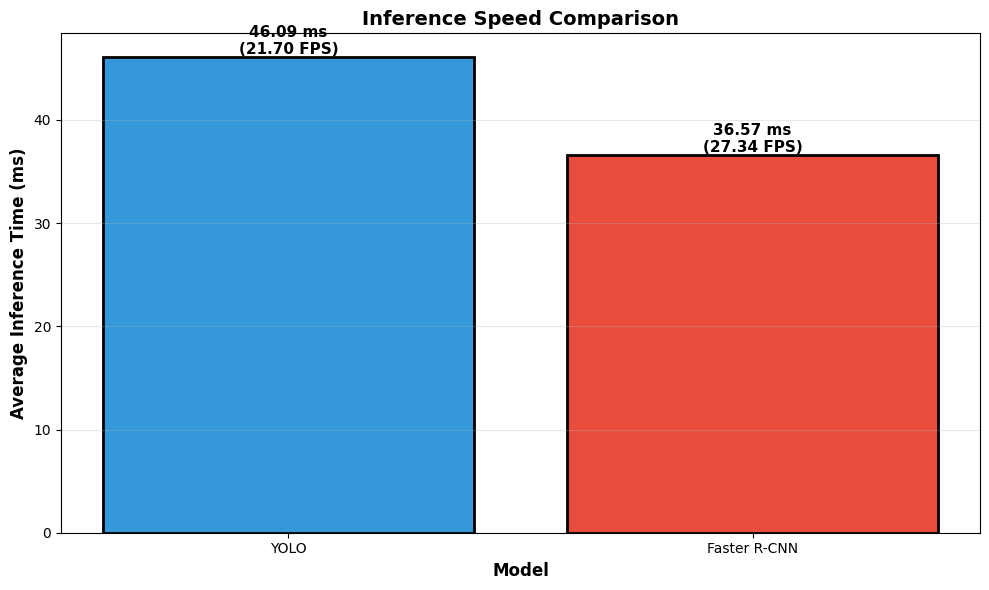

Saved: inference_speed_comparison.png


In [ ]:
# ========== 9.3: Inference speed comparison ==========
print("\n⏱Comparing inference speed...")

import time

# Test YOLO speed
yolo_times = []
test_images = list(val_images[:50])  # Test on 50 images

for img_path in tqdm(test_images, desc="YOLO Inference"):
    start = time.time()
    results = model_yolo_eval(str(img_path), verbose=False)
    yolo_times.append(time.time() - start)

avg_yolo_time = np.mean(yolo_times)
yolo_fps = 1.0 / avg_yolo_time

# Test Faster R-CNN speed
frcnn_times = []
model_frcnn.eval()

for img_path in tqdm(test_images, desc="Faster R-CNN Inference"):
    img = Image.open(img_path).convert("RGB")
    img_tensor = T.ToTensor()(img).unsqueeze(0).to(device)

    start = time.time()
    with torch.no_grad():
        prediction = model_frcnn(img_tensor)
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    frcnn_times.append(time.time() - start)

avg_frcnn_time = np.mean(frcnn_times)
frcnn_fps = 1.0 / avg_frcnn_time

print(f"\nInference Speed Comparison:")
print(f"{'Model':<20} {'Avg Time (ms)':<20} {'FPS':<10}")
print("-" * 50)
print(f"{'YOLO':<20} {avg_yolo_time*1000:.2f}{' ms':<17} {yolo_fps:.2f}")
print(f"{'Faster R-CNN':<20} {avg_frcnn_time*1000:.2f}{' ms':<17} {frcnn_fps:.2f}")
print(f"\n{'Speedup:':<20} {avg_frcnn_time/avg_yolo_time:.2f}x faster (YOLO)")

# Visualize speed comparison
fig, ax = plt.subplots(figsize=(10, 6))

models = ['YOLO', 'Faster R-CNN']
times_ms = [avg_yolo_time * 1000, avg_frcnn_time * 1000]
fps_values = [yolo_fps, frcnn_fps]

x_pos = np.arange(len(models))

bars = ax.bar(x_pos, times_ms, color=['#3498db', '#e74c3c'], edgecolor='black', linewidth=2)
ax.set_ylabel('Average Inference Time (ms)', fontsize=12, fontweight='bold')
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Inference Speed Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(models)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (bar, fps) in enumerate(zip(bars, fps_values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.2f} ms\n({fps:.2f} FPS)',
           ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('inference_speed_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: inference_speed_comparison.png")

- Faster R-CNN: Better inference speed (lower latency, higher FPS).

- YOLO: Slightly slower, but as seen in the previous chart, it had higher detection accuracy.

# Visualize predictions

In [ ]:
print("\n" + "="*70)
print("VISUALIZE KẾT QUẢ DETECTION")
print("="*70)

def visualize_detections_comparison(image_paths, num_images=6):
    """Visualize và so sánh detection của cả 2 model"""

    fig, axes = plt.subplots(num_images, 3, figsize=(18, 6*num_images))

    colors = {
        'with_mask': (0, 255, 0),  # Green
        'without_mask': (255, 0, 0),  # Red
        'mask_weared_incorrect': (255, 165, 0)  # Orange
    }

    idx_to_class = {v: k for k, v in class_to_idx.items()}

    for idx, img_path in enumerate(image_paths[:num_images]):
        # Load image
        img_bgr = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # Original image
        axes[idx, 0].imshow(img_rgb)
        axes[idx, 0].set_title('Original Image', fontsize=12, fontweight='bold')
        axes[idx, 0].axis('off')

        # ========== YOLO Detection ==========
        img_yolo = img_rgb.copy()
        results_yolo = model_yolo_eval(str(img_path), verbose=False)[0]

        for box in results_yolo.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf[0])
            cls = int(box.cls[0])
            label = class_names[cls]

            if conf > 0.5:  # Confidence threshold
                color = colors[label]
                cv2.rectangle(img_yolo, (x1, y1), (x2, y2), color, 2)

                # Label background
                label_text = f'{label}: {conf:.2f}'
                (w, h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                cv2.rectangle(img_yolo, (x1, y1 - 20), (x1 + w, y1), color, -1)
                cv2.putText(img_yolo, label_text, (x1, y1 - 5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        axes[idx, 1].imshow(img_yolo)
        axes[idx, 1].set_title(f'YOLO Detection ({len(results_yolo.boxes)} objects)',
                               fontsize=12, fontweight='bold')
        axes[idx, 1].axis('off')

        # ========== Faster R-CNN Detection ==========
        img_frcnn = img_rgb.copy()
        img_tensor = T.ToTensor()(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)

        with torch.no_grad():
            prediction = model_frcnn(img_tensor)[0]

        boxes = prediction['boxes'].cpu().numpy()
        labels = prediction['labels'].cpu().numpy()
        scores = prediction['scores'].cpu().numpy()

        detected_count = 0
        for box, label, score in zip(boxes, labels, scores):
            if score > 0.5:  # Confidence threshold
                detected_count += 1
                x1, y1, x2, y2 = map(int, box)
                class_name = idx_to_class[label]
                color = colors[class_name]

                cv2.rectangle(img_frcnn, (x1, y1), (x2, y2), color, 2)

                # Label background
                label_text = f'{class_name}: {score:.2f}'
                (w, h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                cv2.rectangle(img_frcnn, (x1, y1 - 20), (x1 + w, y1), color, -1)
                cv2.putText(img_frcnn, label_text, (x1, y1 - 5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        axes[idx, 2].imshow(img_frcnn)
        axes[idx, 2].set_title(f'Faster R-CNN Detection ({detected_count} objects)',
                               fontsize=12, fontweight='bold')
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.savefig('detection_comparison_results.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("Saved: detection_comparison_results.png")

# Visualize comparison
print("\n Creating detection comparison visualization...")
sample_images = list(val_images[10:])
visualize_detections_comparison(sample_images)


Output hidden; open in https://colab.research.google.com to view.


 Creating confusion matrices...


Getting Faster R-CNN predictions: 100%|██████████| 171/171 [00:07<00:00, 22.77it/s]


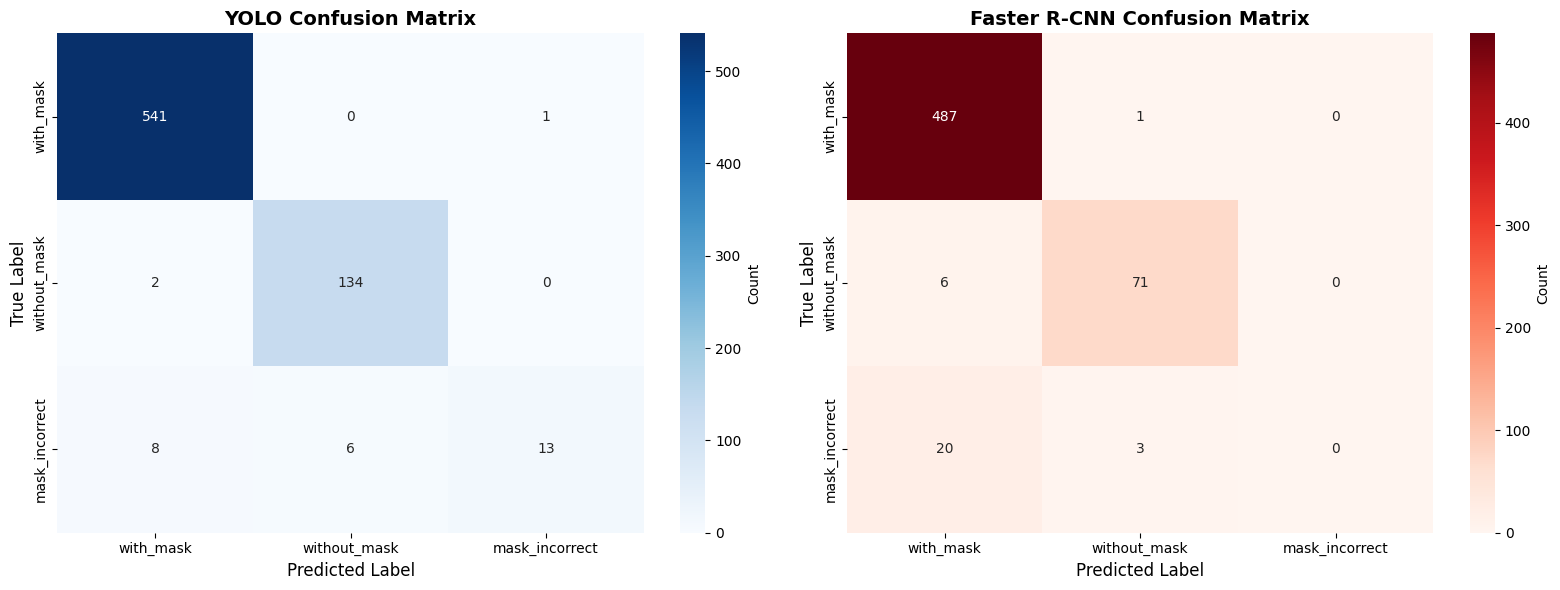

Saved: confusion_matrices.png


In [ ]:

# ========== 10.1: Create confusion matrix for both models ==========
print("\n Creating confusion matrices...")

from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_predictions_for_confusion_matrix(model_type='yolo'):
    """Get predictions and ground truths for confusion matrix"""
    all_preds = []
    all_gts = []

    if model_type == 'yolo':
        for img_path in tqdm(val_images, desc="Getting YOLO predictions"):
            xml_path = annotations_dir / (img_path.stem + '.xml')
            boxes_gt, labels_gt, _, _ = parse_xml_annotation(xml_path)

            results = model_yolo_eval(str(img_path), verbose=False)[0]

            for box_gt, label_gt in zip(boxes_gt, labels_gt):
                all_gts.append(class_to_idx[label_gt] - 1)  # YOLO uses 0-based

                # Find matching prediction
                matched = False
                for box_pred in results.boxes:
                    if float(box_pred.conf[0]) > 0.5:
                        pred_box = box_pred.xyxy[0].cpu().numpy()
                        iou = calculate_iou_metric(box_gt, pred_box)
                        if iou > 0.5:
                            all_preds.append(int(box_pred.cls[0]))
                            matched = True
                            break

                if not matched:
                    all_preds.append(-1)  # No detection

    else:  # Faster R-CNN
        for img_path in tqdm(val_images, desc="Getting Faster R-CNN predictions"):
            xml_path = annotations_dir / (img_path.stem + '.xml')
            boxes_gt, labels_gt, _, _ = parse_xml_annotation(xml_path)

            img_tensor = T.ToTensor()(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)

            with torch.no_grad():
                prediction = model_frcnn(img_tensor)[0]

            boxes_pred = prediction['boxes'].cpu().numpy()
            labels_pred = prediction['labels'].cpu().numpy()
            scores_pred = prediction['scores'].cpu().numpy()

            for box_gt, label_gt in zip(boxes_gt, labels_gt):
                all_gts.append(class_to_idx[label_gt] - 1)

                # Find matching prediction
                matched = False
                for box_pred, label_pred, score_pred in zip(boxes_pred, labels_pred, scores_pred):
                    if score_pred > 0.5:
                        iou = calculate_iou_metric(box_gt, box_pred)
                        if iou > 0.5:
                            all_preds.append(label_pred - 1)
                            matched = True
                            break

                if not matched:
                    all_preds.append(-1)

    return all_preds, all_gts

# Get predictions
yolo_preds, yolo_gts = get_predictions_for_confusion_matrix('yolo')
frcnn_preds, frcnn_gts = get_predictions_for_confusion_matrix('frcnn')

# Create confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

class_labels = ['with_mask', 'without_mask', 'mask_incorrect']

# YOLO confusion matrix
cm_yolo = confusion_matrix(yolo_gts, yolo_preds, labels=[0, 1, 2])
sns.heatmap(cm_yolo, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('YOLO Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Faster R-CNN confusion matrix
cm_frcnn = confusion_matrix(frcnn_gts, frcnn_preds, labels=[0, 1, 2])
sns.heatmap(cm_frcnn, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_labels, yticklabels=class_labels,
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('Faster R-CNN Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: confusion_matrices.png")

Overall Insight

- YOLO provides more reliable and consistent classification across all classes, handling difficult cases better.

- Faster R-CNN is less robust, particularly with nuanced or low-sample categories.

- This supports earlier findings: YOLO’s higher mAP and F1-score are reflected in its cleaner confusion matrix.

**Comparative Analysis of YOLO and Faster R-CNN**

The overall evaluation highlights clear trade-offs between **YOLO** and **Faster R-CNN** in both performance and speed.
From the **model performance metrics**, YOLO consistently achieves higher scores across all indicators — notably **mAP@50 (0.812 vs. 0.559)**, **mAP@50–95 (0.551 vs. 0.336)**, and slightly better **Precision (0.901 vs. 0.892)** and **Recall (0.730 vs. 0.707)**. This leads to a higher **F1-score (0.807 vs. 0.789)**, confirming YOLO’s stronger overall accuracy and robustness in detection.
However, when comparing **inference speed**, **Faster R-CNN** demonstrates an advantage with an average of **36.57 ms per image (27.34 FPS)**, outperforming YOLO’s **46.09 ms (21.70 FPS)** — indicating faster real-time processing capability.
The **confusion matrices** further support these findings: YOLO shows balanced, accurate classification across all mask categories, including challenging cases like *mask_incorrect*, whereas Faster R-CNN struggles with this class, misclassifying most instances as *with_mask*.
In summary, **YOLO delivers superior detection accuracy and class consistency**, while **Faster R-CNN offers slightly faster inference speed**, representing the classic **accuracy–speed trade-off** common in object detection models.


In [ ]:
!zip -r /content/session_files.zip /content
from google.colab import files
files.download('/content/session_files.zip')


  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.10.30/ (stored 0%)
  adding: content/.config/logs/2025.10.30/13.35.52.212263.log (deflated 86%)
  adding: content/.config/logs/2025.10.30/13.35.42.751639.log (deflated 58%)
  adding: content/.config/logs/2025.10.30/13.35.10.281184.log (deflated 92%)
  adding: content/.config/logs/2025.10.30/13.36.07.857469.log (deflated 57%)
  adding: content/.config/logs/2025.10.30/13.35.58.184082.log (deflated 58%)
  adding: content/.config/logs/2025.10.30/13.36.08.663879.log (deflated 56%)
  adding: content/.c

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>